In [ ]:
# Uncomment and run if installation does not exist in environment
#%pip install numpy
#%pip install pandas
#%pip install nibabel
#%pip install seaborn
#%pip install matplotlib
#%pip install nilearn
#%pip install pyrelimri

In [1]:
import sys
import os
import argparse
import warnings
import numpy as np
import pandas as pd
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn import image, masking, plotting
from glob import glob
from pyrelimri import similarity
from itertools import product
warnings.filterwarnings("ignore")

/home/users/demidenm/.local/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 3.2.1'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def extract_median(img_list, mask_img):
    data_list = []
    for img in img_list:
        base_name = os.path.basename(img)
        mask, con, mni, motion, model, fwhm = base_name.split('_')[2:8]
    
        # get median value
        nifti_img = image.load_img(img)
        masked_data = masking.apply_mask(nifti_img, mask_img)
        median_est = np.round(np.median(masked_data), 3)
        
        data_list.append({
            'mask': mask,
            'con': con,
            'motion': motion,
            'model': model,
            'fwhm': fwhm,
            'median_est': median_est
        })
    return pd.DataFrame(data_list)

def file_exists(file_path):
    return os.path.exists(file_path)

# if file doesnt exist, extract media and create file, otherwise load file 
def process_dataset(imgs, mask, out_file):
    if not file_exists(out_file):
        print(f'file {out_file} doesnt exist, creating')
        df = extract_median(imgs, mask)
        df.to_csv(out_file, sep='\t', index=False)
    else:
        print(f'Loading existing {out_file}')
        df = pd.read_csv(out_file, sep='\t')
    return df

def mean_sd_img(list_imgs):
    # get data and stack it
    img_list = [image.load_img(img_path) for img_path in list_imgs]
    img_data = np.stack([img.get_fdata() for img in img_list], axis=-1)
    # calculate the mean + sd image
    mean_img_data = np.mean(img_data, axis=-1)
    sd_img_data = np.std(img_data, axis=-1)
    # convert back into space of icc imgs
    icc_mean_img = image.new_img_like(img_list[0], mean_img_data)
    icc_sd_img = image.new_img_like(img_list[0], sd_img_data)
    # return mean + sd img
    return icc_mean_img,icc_sd_img

In [3]:
sample='MLS' # sample, AHRB, MLS or abcd
calc_type='session' # session or run
data_path=f'/oak/stanford/groups/russpold/data/{sample}'
out_dir=f'{data_path}/derivatives/analyses/proj_reliability'
icc_est=f'{out_dir}/icc_mods/{calc_type}'
group_out=f'{out_dir}/group'

In [4]:
# load images
# icc
icc_supra_imgs = sorted(glob(f'{icc_est}/**/*wilson-supra_*stat-est.nii.gz'))
icc_sub_imgs = sorted(glob(f'{icc_est}/**/*wilson-sub_*stat-est.nii.gz'))
# msbs 
bs_supra_imgs = sorted(glob(f'{icc_est}/**/*wilson-supra_*stat-msbtwn.nii.gz'))
bs_sub_imgs = sorted(glob(f'{icc_est}/**/*wilson-sub_*stat-msbtwn.nii.gz'))
# msws
ws_supra_imgs = sorted(glob(f'{icc_est}/**/*wilson-supra_*stat-mswthn.nii.gz'))
ws_sub_imgs = sorted(glob(f'{icc_est}/**/*wilson-sub_*stat-mswthn.nii.gz'))

print("Acquired lists:",
      len(icc_supra_imgs),len(icc_sub_imgs), 
      len(bs_supra_imgs),len(bs_sub_imgs),len(ws_supra_imgs),len(ws_sub_imgs))

Acquired lists: 240 240 240 240 240 240


In [5]:
# load sub and supra masks
mask_supra = f'{data_path}/code/proj_reliability/Multiverse_Reliability/Stage2_Code/brain_mask/MNI152_wilson-supra.nii.gz'
mask_sub = f'{data_path}/code/proj_reliability/Multiverse_Reliability/Stage2_Code/brain_mask/MNI152_wilson-sub.nii.gz'

In [6]:
# icc
out_icc_supra = f'{out_dir}/file_output/sample-{sample}_type-{calc_type}_stats-est_mask-wilson-supra.tsv'
out_icc_sub = f'{out_dir}/file_output/sample-{sample}_type-{calc_type}_stats-est_mask-wilson-sub.tsv'
# msbs
out_bs_supra = f'{out_dir}/file_output/sample-{sample}_type-{calc_type}_stats-bs_mask-wilson-supra.tsv'
out_bs_sub = f'{out_dir}/file_output/sample-{sample}_type-{calc_type}_stats-bs_mask-wilson-sub.tsv'
# msws
out_ws_supra = f'{out_dir}/file_output/sample-{sample}_type-{calc_type}_stats-ws_mask-wilson-supra.tsv'
out_ws_sub = f'{out_dir}/file_output/sample-{sample}_type-{calc_type}_stats-ws_mask-wilson-sub.tsv'
# similarity 
out_similarity= f'{out_dir}/file_output/sample-{sample}_type-{calc_type}_stats-similarity.tsv'

# Means and Stand Dev of Estimates

For Aim 1 (ICC estimate) and Aim 2 (Mean Square Between Subject and Within Subject Variance), stated would include:

"First, voxel-wise average and standard deviation from the resulting ICCs for the 360 model permutations are reported in two 3D volumes."

Selected coordinated (L) Ventral Striatum based on Neurosynth search term "ventral striatum" threshold > 20

## ICC est

In [7]:
icc_mean_supra, icc_sd_supra = mean_sd_img(icc_supra_imgs)
icc_mean_sub, icc_sd_sub = mean_sd_img(icc_sub_imgs)

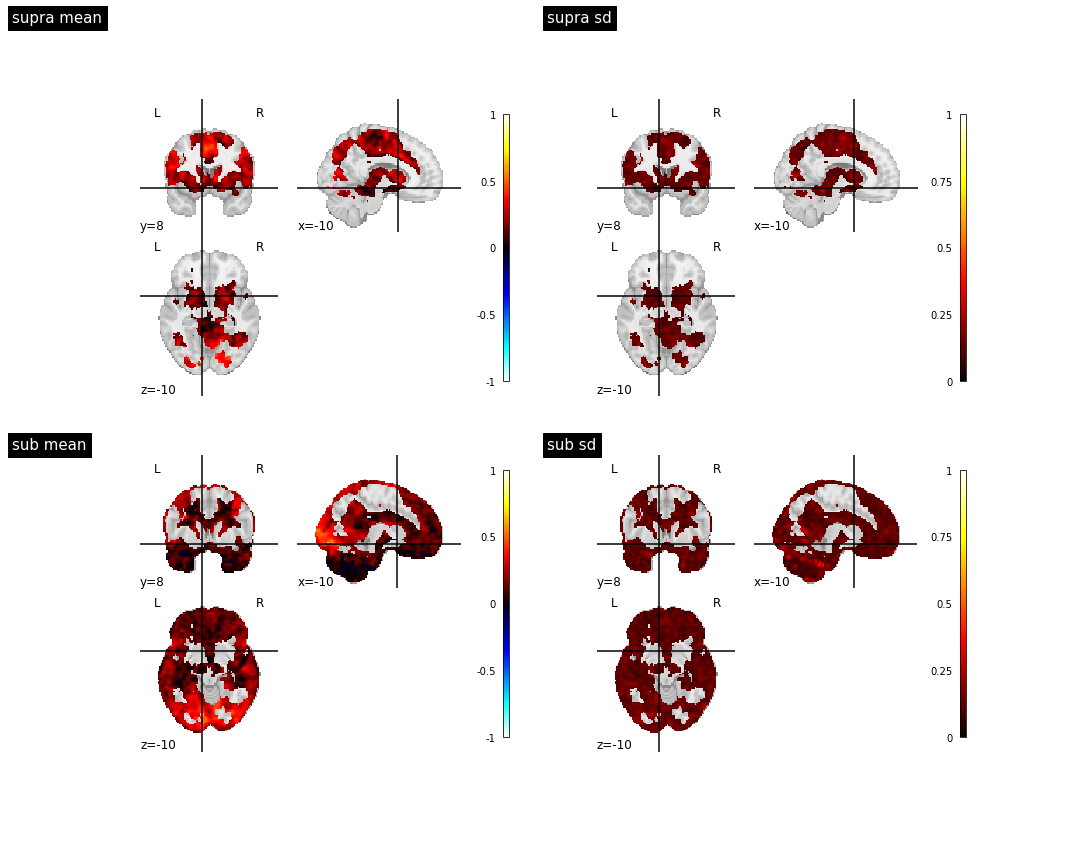

In [8]:
icc_maps = [icc_mean_supra, icc_sd_supra, icc_mean_sub, icc_sd_sub]
icc_names = ['icc_mean_supra', 'icc_sd_supra', 'icc_mean_sub', 'icc_sd_sub']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
for i, map_type in enumerate(icc_maps):
    labels = icc_names[i].split('_')
    est_lab = labels[1]
    thresh_lab = labels[2]

    # position
    row = i // 2
    col = i % 2

    # Plot the current map in the corresponding subplot
    plotting.plot_stat_map(map_type, display_mode='tiled', title=f'{thresh_lab} {est_lab}',
                           cut_coords=(-10, 8, -10), vmax=1, axes=axes[row, col])

plt.tight_layout()
plt.show()

## MSBS est

In [9]:
bs_mean_supra, bs_sd_supra = mean_sd_img(bs_supra_imgs)
bs_mean_sub, bs_sd_sub = mean_sd_img(bs_sub_imgs)

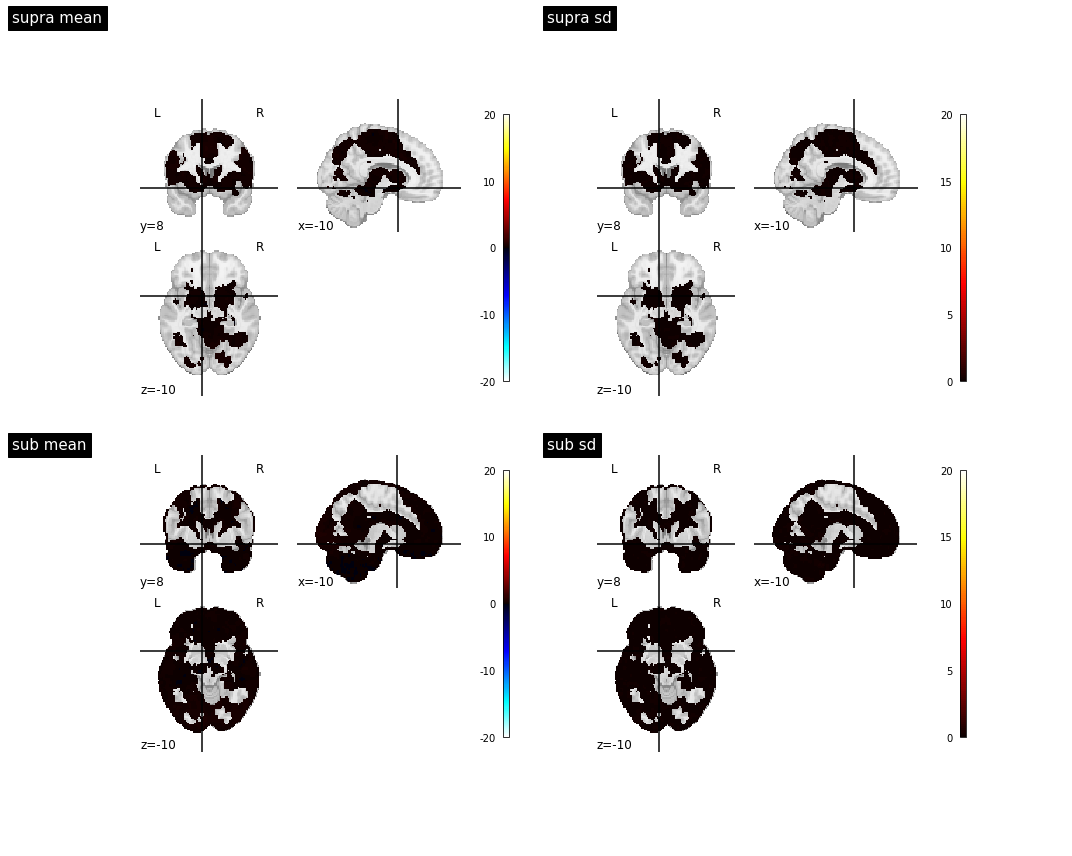

In [13]:
bs_maps = [bs_mean_supra, bs_sd_supra, bs_mean_sub, bs_sd_sub]
bs_names = ['bs_mean_supra', 'bs_sd_supra', 'bs_mean_sub', 'bs_sd_sub']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
for i, map_type in enumerate(icc_maps):
    labels = bs_names[i].split('_')
    est_lab = labels[1]
    thresh_lab = labels[2]
    
    row = i // 2
    col = i % 2
    
    plotting.plot_stat_map(map_type, display_mode='tiled', title=f'{thresh_lab} {est_lab}',
                           cut_coords=(-10, 8, -10), vmax=20, axes=axes[row, col])

plt.tight_layout()
plt.show()

## MSWS est

In [11]:
ws_mean_supra, ws_sd_supra = mean_sd_img(ws_supra_imgs)
ws_mean_sub, ws_sd_sub = mean_sd_img(ws_sub_imgs)

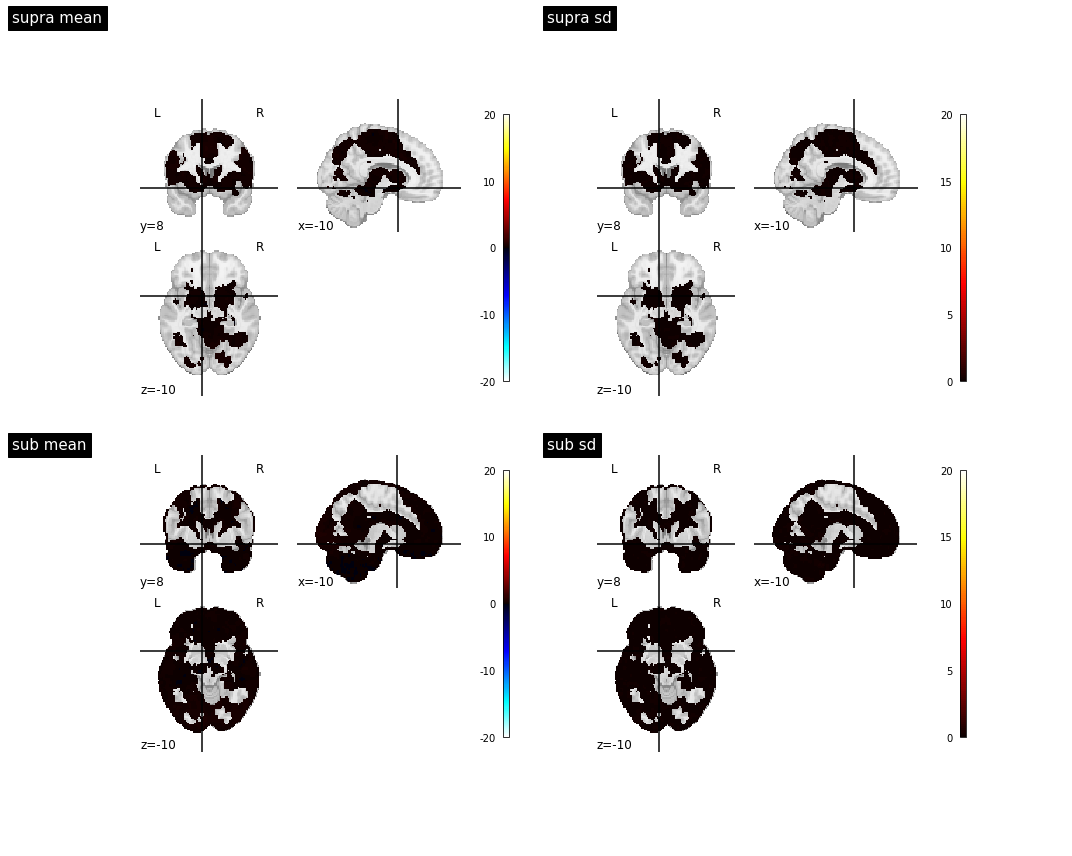

In [14]:
ws_maps = [ws_mean_supra, ws_sd_supra, ws_mean_sub, ws_sd_sub]
ws_names = ['ws_mean_supra', 'ws_sd_supra', 'ws_mean_sub', 'ws_sd_sub']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
for i, map_type in enumerate(icc_maps):
    labels = bs_names[i].split('_')
    est_lab = labels[1]
    thresh_lab = labels[2]
    
    row = i // 2
    col = i % 2
    
    plotting.plot_stat_map(map_type, display_mode='tiled', title=f'{thresh_lab} {est_lab}',
                           cut_coords=(-10, 8, -10), vmax=20, axes=axes[row, col])

plt.tight_layout()
plt.show()

# Loading files, Extracting median ICC and providing distribution

For Aim 1 and Aim 2 state would include:
"Second, the range and distribution of median ICCs across each study (three) and analytic decision category (four) are plotted across suprathreshold task-positive and subthreshold ICCs using Rainclouds (Allen et al., 2019) and the median and standard deviation is reported in a table."

While included here to rank and contain some information, plots will be created in R using raincloud features that are more powerful

In [16]:
# icc datasets
df_icc_supra = process_dataset(icc_supra_imgs, mask_supra, out_icc_supra)
df_icc_sub = process_dataset(icc_sub_imgs, mask_sub, out_icc_sub)

# msbs datasets
df_bs_supra = process_dataset(bs_supra_imgs, mask_supra, out_bs_supra)
df_bs_sub = process_dataset(bs_sub_imgs, mask_sub, out_bs_sub)

# msws datasets
df_ws_supra = process_dataset(ws_supra_imgs, mask_supra, out_ws_supra)
df_ws_sub = process_dataset(ws_sub_imgs, mask_sub, out_ws_sub)

file /oak/stanford/groups/russpold/data/MLS/derivatives/analyses/proj_reliability/file_output/sample-MLS_type-session_stats-est_mask-wilson-supra.tsv doesnt exist, creating
file /oak/stanford/groups/russpold/data/MLS/derivatives/analyses/proj_reliability/file_output/sample-MLS_type-session_stats-est_mask-wilson-sub.tsv doesnt exist, creating
file /oak/stanford/groups/russpold/data/MLS/derivatives/analyses/proj_reliability/file_output/sample-MLS_type-session_stats-bs_mask-wilson-supra.tsv doesnt exist, creating
file /oak/stanford/groups/russpold/data/MLS/derivatives/analyses/proj_reliability/file_output/sample-MLS_type-session_stats-bs_mask-wilson-sub.tsv doesnt exist, creating
file /oak/stanford/groups/russpold/data/MLS/derivatives/analyses/proj_reliability/file_output/sample-MLS_type-session_stats-ws_mask-wilson-supra.tsv doesnt exist, creating
file /oak/stanford/groups/russpold/data/MLS/derivatives/analyses/proj_reliability/file_output/sample-MLS_type-session_stats-ws_mask-wilson-sub

### sort ICC by median est + img of highest

In [17]:
df_icc_supra.sort_values(by='median_est', ascending=False)

,mask,con,motion,model,fwhm,median_est
14,mask-wilson-supra,contrast-Lgain-Base,mot-opt1,mod-FixMod,fwhm-7.0,0.473
13,mask-wilson-supra,contrast-Lgain-Base,mot-opt1,mod-FixMod,fwhm-6.0,0.458
12,mask-wilson-supra,contrast-Lgain-Base,mot-opt1,mod-FixMod,fwhm-5.0,0.437
134,mask-wilson-supra,contrast-Sgain-Base,mot-opt1,mod-FixMod,fwhm-7.0,0.430
29,mask-wilson-supra,contrast-Lgain-Base,mot-opt2,mod-FixMod,fwhm-7.0,0.416
...,...,...,...,...,...,...
210,mask-wilson-supra,contrast-Sgain-Neut,mot-opt3,mod-AntMod,fwhm-3.0,0.067
230,mask-wilson-supra,contrast-Sgain-Neut,mot-opt4,mod-CueMod,fwhm-3.0,0.067
225,mask-wilson-supra,contrast-Sgain-Neut,mot-opt4,mod-AntMod,fwhm-3.0,0.066
235,mask-wilson-supra,contrast-Sgain-Neut,mot-opt4,mod-FixMod,fwhm-3.0,0.058


In [18]:
df_icc_sub.sort_values(by='median_est', ascending=False)

,mask,con,motion,model,fwhm,median_est
14,mask-wilson-sub,contrast-Lgain-Base,mot-opt1,mod-FixMod,fwhm-7.0,0.320
129,mask-wilson-sub,contrast-Sgain-Base,mot-opt1,mod-CueMod,fwhm-7.0,0.319
9,mask-wilson-sub,contrast-Lgain-Base,mot-opt1,mod-CueMod,fwhm-7.0,0.312
13,mask-wilson-sub,contrast-Lgain-Base,mot-opt1,mod-FixMod,fwhm-6.0,0.299
128,mask-wilson-sub,contrast-Sgain-Base,mot-opt1,mod-CueMod,fwhm-6.0,0.298
...,...,...,...,...,...,...
215,mask-wilson-sub,contrast-Sgain-Neut,mot-opt3,mod-CueMod,fwhm-3.0,0.042
210,mask-wilson-sub,contrast-Sgain-Neut,mot-opt3,mod-AntMod,fwhm-3.0,0.041
225,mask-wilson-sub,contrast-Sgain-Neut,mot-opt4,mod-AntMod,fwhm-3.0,0.040
220,mask-wilson-sub,contrast-Sgain-Neut,mot-opt3,mod-FixMod,fwhm-3.0,0.038


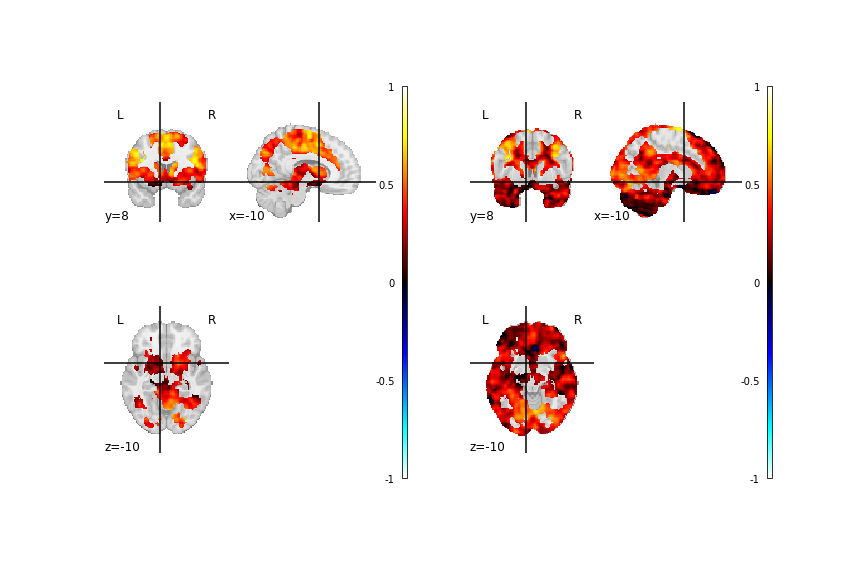

In [26]:
icc_maps = [icc_supra_imgs, icc_sub_imgs]
icc_img = 14

fig, axes = plt.subplots(1, 2, figsize=(12, 8))

for i, map_type in enumerate(icc_maps):
    plotting.plot_stat_map(map_type[icc_img], display_mode='tiled',
                           cut_coords=(-10, 8, -10), vmax=1, axes=axes[i])
plt.tight_layout()
plt.show()

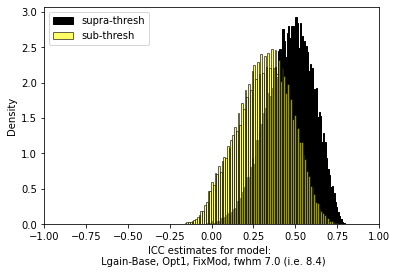

In [29]:
masked_supra_data = masking.apply_mask(icc_supra_imgs[icc_img], mask_supra)
masked_sub_data = masking.apply_mask(icc_sub_imgs[icc_img], mask_sub)

# Plot the distribution
plt.hist(np.round(masked_supra_data, decimals=3), bins=100, edgecolor='black', color='black',
         alpha=1, label='supra-thresh', density=True)  # supra-threshold mask

plt.hist(np.round(masked_sub_data, decimals=3), bins=100, edgecolor='black', color='yellow',
         alpha=0.6, label='sub-thresh', density=True)  # sub-threshold mask

plt.xlim(-1,1)
plt.xlabel('ICC estimates for model: \n Lgain-Base, Opt1, FixMod, fwhm 7.0 (i.e. 8.4)')
plt.ylabel('Density') 
plt.legend()
plt.show()

### sort MSBS by median est + img of highest

In [19]:
df_bs_supra.sort_values(by='median_est', ascending=False)

,mask,con,motion,model,fwhm,median_est
10,mask-wilson-supra,contrast-Lgain-Base,mot-opt1,mod-FixMod,fwhm-3.0,2.594
25,mask-wilson-supra,contrast-Lgain-Base,mot-opt2,mod-FixMod,fwhm-3.0,2.537
130,mask-wilson-supra,contrast-Sgain-Base,mot-opt1,mod-FixMod,fwhm-3.0,2.297
145,mask-wilson-supra,contrast-Sgain-Base,mot-opt2,mod-FixMod,fwhm-3.0,2.244
11,mask-wilson-supra,contrast-Lgain-Base,mot-opt1,mod-FixMod,fwhm-4.0,2.205
...,...,...,...,...,...,...
109,mask-wilson-supra,contrast-Lgain-Neut,mot-opt4,mod-AntMod,fwhm-7.0,0.039
228,mask-wilson-supra,contrast-Sgain-Neut,mot-opt4,mod-AntMod,fwhm-6.0,0.037
213,mask-wilson-supra,contrast-Sgain-Neut,mot-opt3,mod-AntMod,fwhm-6.0,0.036
229,mask-wilson-supra,contrast-Sgain-Neut,mot-opt4,mod-AntMod,fwhm-7.0,0.030


In [20]:
df_bs_sub.sort_values(by='median_est', ascending=False)

,mask,con,motion,model,fwhm,median_est
10,mask-wilson-sub,contrast-Lgain-Base,mot-opt1,mod-FixMod,fwhm-3.0,3.788
5,mask-wilson-sub,contrast-Lgain-Base,mot-opt1,mod-CueMod,fwhm-3.0,3.565
130,mask-wilson-sub,contrast-Sgain-Base,mot-opt1,mod-FixMod,fwhm-3.0,3.525
25,mask-wilson-sub,contrast-Lgain-Base,mot-opt2,mod-FixMod,fwhm-3.0,3.462
125,mask-wilson-sub,contrast-Sgain-Base,mot-opt1,mod-CueMod,fwhm-3.0,3.457
...,...,...,...,...,...,...
109,mask-wilson-sub,contrast-Lgain-Neut,mot-opt4,mod-AntMod,fwhm-7.0,0.068
228,mask-wilson-sub,contrast-Sgain-Neut,mot-opt4,mod-AntMod,fwhm-6.0,0.063
213,mask-wilson-sub,contrast-Sgain-Neut,mot-opt3,mod-AntMod,fwhm-6.0,0.062
229,mask-wilson-sub,contrast-Sgain-Neut,mot-opt4,mod-AntMod,fwhm-7.0,0.051


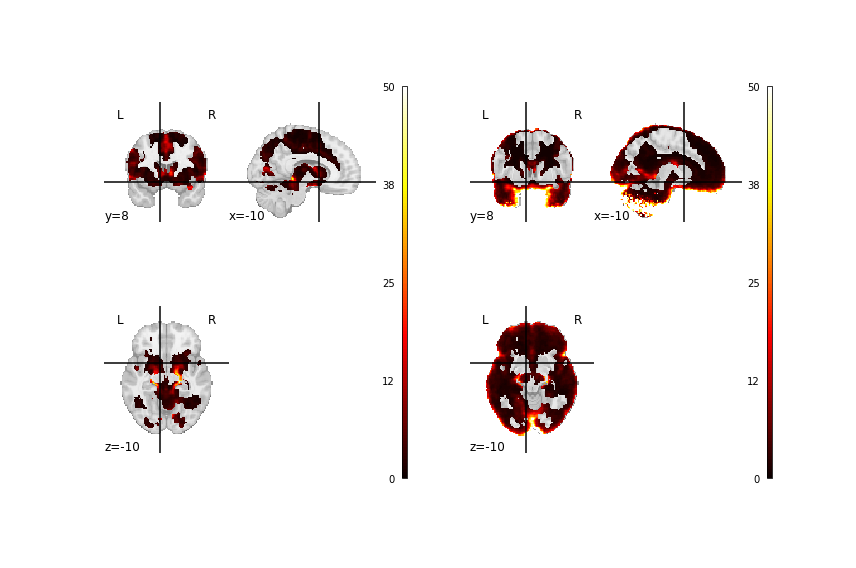

In [30]:
bs_maps = [bs_supra_imgs, bs_sub_imgs]
bs_img = 25

fig, axes = plt.subplots(1, 2, figsize=(12, 8))

for i, map_type in enumerate(bs_maps):
    plotting.plot_stat_map(map_type[bs_img], display_mode='tiled',
                           cut_coords=(-10, 8, -10), axes=axes[i], vmax=50)
plt.tight_layout()
plt.show()

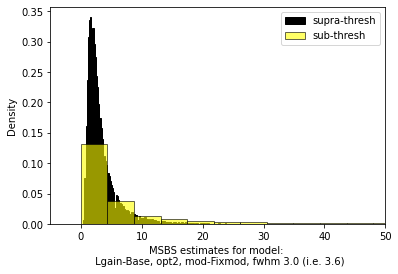

In [32]:
masked_supra_data = masking.apply_mask(bs_supra_imgs[bs_img], mask_supra)
masked_sub_data = masking.apply_mask(bs_sub_imgs[bs_img], mask_sub)

# Plot the distribution
plt.hist(np.round(masked_supra_data, decimals=1), bins=500, edgecolor='black',  color='black',
         alpha = 1, label='supra-thresh', density=True)  # supra-threshold mask
plt.hist(np.round(masked_sub_data, decimals=1), bins=500, edgecolor='black', color='yellow', 
         alpha = .6, label='sub-thresh', density=True)  # sub-threshold mask

plt.xlabel('MSBS estimates for model: \n Lgain-Base, opt2, mod-Fixmod, fwhm 3.0 (i.e. 3.6)')
plt.ylabel('Density')
# Set x-axis limits
plt.xlim(-5, 50)
plt.legend()
plt.show()

### sort MSWS by median est + img of highest

In [21]:
df_ws_supra.sort_values(by='median_est', ascending=False)

,mask,con,motion,model,fwhm,median_est
25,mask-wilson-supra,contrast-Lgain-Base,mot-opt2,mod-FixMod,fwhm-3.0,1.235
145,mask-wilson-supra,contrast-Sgain-Base,mot-opt2,mod-FixMod,fwhm-3.0,1.191
10,mask-wilson-supra,contrast-Lgain-Base,mot-opt1,mod-FixMod,fwhm-3.0,1.106
130,mask-wilson-supra,contrast-Sgain-Base,mot-opt1,mod-FixMod,fwhm-3.0,1.103
55,mask-wilson-supra,contrast-Lgain-Base,mot-opt4,mod-FixMod,fwhm-3.0,1.100
...,...,...,...,...,...,...
213,mask-wilson-supra,contrast-Sgain-Neut,mot-opt3,mod-AntMod,fwhm-6.0,0.030
94,mask-wilson-supra,contrast-Lgain-Neut,mot-opt3,mod-AntMod,fwhm-7.0,0.027
109,mask-wilson-supra,contrast-Lgain-Neut,mot-opt4,mod-AntMod,fwhm-7.0,0.027
229,mask-wilson-supra,contrast-Sgain-Neut,mot-opt4,mod-AntMod,fwhm-7.0,0.024


In [22]:
df_ws_sub.sort_values(by='median_est', ascending=False)

,mask,con,motion,model,fwhm,median_est
10,mask-wilson-sub,contrast-Lgain-Base,mot-opt1,mod-FixMod,fwhm-3.0,2.074
130,mask-wilson-sub,contrast-Sgain-Base,mot-opt1,mod-FixMod,fwhm-3.0,2.029
25,mask-wilson-sub,contrast-Lgain-Base,mot-opt2,mod-FixMod,fwhm-3.0,1.967
5,mask-wilson-sub,contrast-Lgain-Base,mot-opt1,mod-CueMod,fwhm-3.0,1.951
145,mask-wilson-sub,contrast-Sgain-Base,mot-opt2,mod-FixMod,fwhm-3.0,1.924
...,...,...,...,...,...,...
213,mask-wilson-sub,contrast-Sgain-Neut,mot-opt3,mod-AntMod,fwhm-6.0,0.050
109,mask-wilson-sub,contrast-Lgain-Neut,mot-opt4,mod-AntMod,fwhm-7.0,0.047
94,mask-wilson-sub,contrast-Lgain-Neut,mot-opt3,mod-AntMod,fwhm-7.0,0.046
229,mask-wilson-sub,contrast-Sgain-Neut,mot-opt4,mod-AntMod,fwhm-7.0,0.041


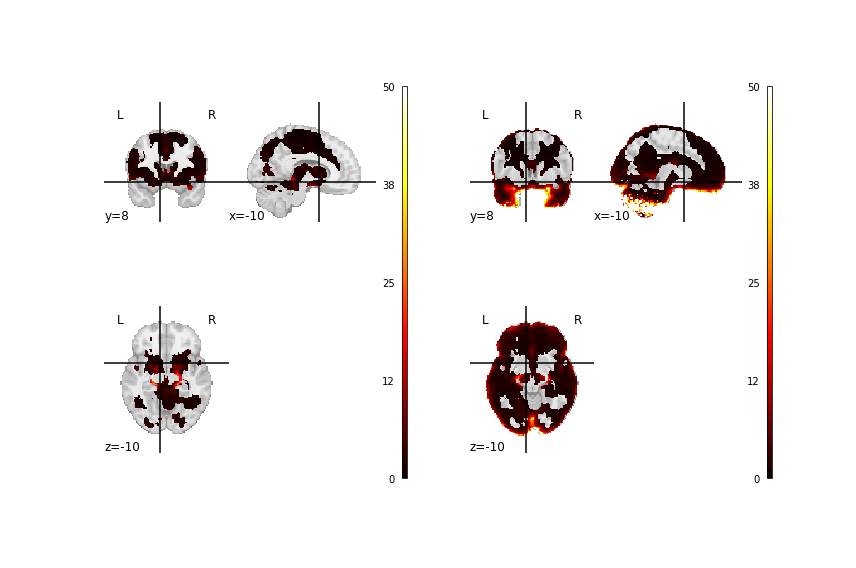

In [33]:
ws_maps = [ws_supra_imgs, ws_sub_imgs]
ws_img = 25

fig, axes = plt.subplots(1, 2, figsize=(12, 8))

for i, map_type in enumerate(ws_maps):
    plotting.plot_stat_map(map_type[ws_img], display_mode='tiled',
                           cut_coords=(-10, 8, -10), vmax=50, axes=axes[i])
plt.tight_layout()
plt.show()

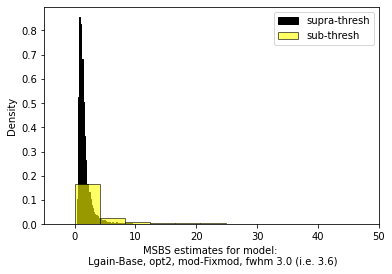

In [36]:
masked_supra_data = masking.apply_mask(ws_supra_imgs[ws_img], mask_supra)
masked_sub_data = masking.apply_mask(ws_sub_imgs[ws_img], mask_sub)

# Plot the distribution
plt.hist(np.round(masked_supra_data, decimals=1), bins=500, edgecolor='black',  color='black',
         alpha = 1, label='supra-thresh', density = True)  # supra-threshold mask
plt.hist(np.round(masked_sub_data, decimals=1), bins=500, edgecolor='black', color='yellow', 
         alpha = .6, label='sub-thresh', density = True)  # sub-threshold mask

plt.xlabel('MSBS estimates for model: \n Lgain-Base, opt2, mod-Fixmod, fwhm 3.0 (i.e. 3.6)')
plt.ylabel('Density')
plt.xlim(-5,50)
plt.legend()
plt.show()

# Group-wise similarity

## Jaccards & spearman similarity

As described in the registered report:

*"Jaccard similarity coefficient is sensitive to thresholding and sample size (Bennett & Miller, 2010), in Aim 1 an equal sample size (e.g., N ~ 60) is chosen for each study to compare how the similarity between sessions varies across studies. For all 360 pipelines, a group-level (average) activation map is estimated for each session. In the case of the Jaccard coefficient, the group maps are thresholded at p < .001. In the case of the Spearman coefficient, the group maps are masked using a suprathreshold task-positive map from NeuroVault. Then, the paths for the pipelines and sessions are called using the pairwise_similarity within the similarity.py script. The resulting coefficients report the similarity between analytic pipelines and sessions for each study. For each study, the coefficients are plotted to reflect the distribution and range of coefficients. Both Jaccards and Spearman correlation are reported separately. Like Aim 1 & Aim 2, two HLMs are used to regress the Jaccard coefficients and Spearman correlation on the [four] analytic decisions nested within study. Multiple comparisons corrections are applied using the Tukey adjustment."*

In [34]:
contrasts = [
    'Lgain-Neut', 'Sgain-Neut',
    'Lgain-Base', 'Sgain-Base'
]

# Model permutations
if sample in ['abcd', 'AHRB']:
    voxel = 2.4
    opts = np.array([1.5,  2, 2.5, 3, 3.5])
    fwhm_opt = list(np.round(voxel * opts, 1))
elif sample in 'MLS':
    voxel = 4
    inh_smooth_weight = .50
    opts = np.array([1.5, 2, 2.5, 3, 3.5])*inh_smooth_weight
    fwhm_opt = list(np.round(voxel * opts, 1))

# only including 4; opt 5 is opt3 + subj mFD < .9 & opt6 is opt4 + subj mFD < .9. 
motion_opt = ["opt1", "opt2", "opt3", "opt4"]
modtype_opt = ["CueMod", "AntMod", "FixMod"]

permutation_list = list(product(contrasts, fwhm_opt, motion_opt, modtype_opt))

In [39]:
threshold = .4 # mod since t -> d transform
similar_list = []
n = 0
for con, fwhm, motion, model in permutation_list:
    n = n + 1
    print(f'Running {n} out of {len(permutation_list)}')
    # jaccard/ spearman similarity between session 1 and session 2
    img1 = f'{group_out}/ses-1/{calc_type}/*contrast-{con}_mask-mni152_mot-{motion}_mod-{model}_fwhm-{fwhm}_stat-cohensd.nii.gz'
    img2 = f'{group_out}/ses-2/{calc_type}/*contrast-{con}_mask-mni152_mot-{motion}_mod-{model}_fwhm-{fwhm}_stat-cohensd.nii.gz'
    jaccard = similarity.image_similarity(imgfile1=img1, imgfile2=img2, thresh = threshold, similarity_type = 'jaccard')
    spearman = similarity.image_similarity(imgfile1=img1, imgfile2=img2, mask=mask_supra, similarity_type = 'spearman')
    
    # spearman rho between session ICC + sess 1 & sess 2 cohens d
    ses_icc = f'{icc_est}/**/*wilson-supra_contrast-{con}_mask-mni152_mot-{motion}_mod-{model}_fwhm-{fwhm}*stat-est.nii.gz'
    ses1 = f'{group_out}/ses-1/{calc_type}/*contrast-{con}_mask-mni152_mot-{motion}_mod-{model}_fwhm-{fwhm}_stat-cohensd.nii.gz'
    ses2 = f'{group_out}/ses-2/{calc_type}/*contrast-{con}_mask-mni152_mot-{motion}_mod-{model}_fwhm-{fwhm}_stat-cohensd.nii.gz'
    ses1_spear = similarity.image_similarity(imgfile1=ses_icc, imgfile2=ses1, mask=mask_supra, similarity_type = 'spearman')
    ses2_spear = similarity.image_similarity(imgfile1=ses_icc, imgfile2=ses2, mask=mask_supra, similarity_type = 'spearman')


    similar_list.append({
        'con': con,
        'fwhm': fwhm,
        'motion': motion,
        'model': model,
        'jaccard': jaccard,
        'spearman': spearman,
        'ses1_icc_cohensd': ses1_spear,
        'ses2_icc_cohensd': ses2_spear,
        
    })
 

Running 1 out of 240
Running 2 out of 240
Running 3 out of 240
Running 4 out of 240
Running 5 out of 240
Running 6 out of 240
Running 7 out of 240
Running 8 out of 240
Running 9 out of 240
Running 10 out of 240
Running 11 out of 240
Running 12 out of 240
Running 13 out of 240
Running 14 out of 240
Running 15 out of 240
Running 16 out of 240
Running 17 out of 240
Running 18 out of 240
Running 19 out of 240
Running 20 out of 240
Running 21 out of 240
Running 22 out of 240
Running 23 out of 240
Running 24 out of 240
Running 25 out of 240
Running 26 out of 240
Running 27 out of 240
Running 28 out of 240
Running 29 out of 240
Running 30 out of 240
Running 31 out of 240
Running 32 out of 240
Running 33 out of 240
Running 34 out of 240
Running 35 out of 240
Running 36 out of 240
Running 37 out of 240
Running 38 out of 240
Running 39 out of 240
Running 40 out of 240
Running 41 out of 240
Running 42 out of 240
Running 43 out of 240
Running 44 out of 240
Running 45 out of 240
Running 46 out of 2

In [40]:
similarity_df = pd.DataFrame(similar_list)
similarity_df.to_csv(out_similarity, sep='\t', index=False)

## Posthc, Session Group Map ~ Session ICC

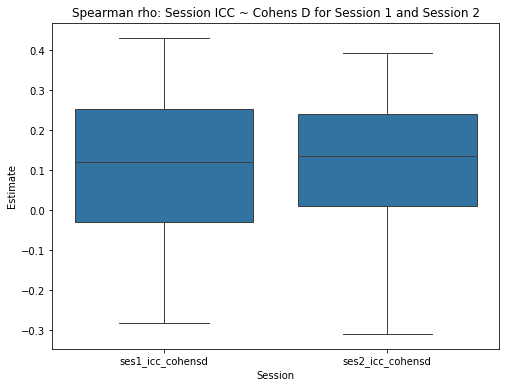

In [42]:
spear_sim_df = pd.DataFrame(similarity_df[['ses1_icc_cohensd','ses2_icc_cohensd']])
spear_sim_long = pd.melt(spear_sim_df, var_name="Session", value_name="SpearmanEstimate")

# Boxplot Spearman rho between Session 1 (or 2) Group Cohen's D map ~ Session ICC est. masked suprathresh
plt.figure(figsize=(8, 6))
sns.boxplot(x="Session", y="SpearmanEstimate", data=spear_sim_long)
plt.ylabel('Estimate')
plt.title('Spearman rho: Session ICC ~ Cohens D for Session 1 and Session 2')

# Show the plot
plt.show()